Import needed packages.

- os -- to search in directories and acquire path names
- string -- to manipulate data in string format, create file names, etc
- numpy -- for performing math operations and manipulating data in multidimensional arrays
- h5py -- for reading from and writing to HDF5 files
- pandas -- for management of large databases

The h5py package manual is here: https://docs.h5py.org/en/stable/

The pandas package manual is here: https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html


In [1]:
import os
import string
import numpy as np
import h5py
import pandas as pd

First, as we will need to look at the data in one file (though our goal is to perform the same action in a loop over every file), we need to provide a specific folder we will use for testing.

In [2]:
test_run = "nrrb_data_d2_w0.0_wt0.0_lambda0.0_m1.0_Nx21_Nt80_dt0.05_nL1000000_eps0.0001_mu-0.2"

Then, we specify the data directory and then identify the output files from the simulation code.

In [3]:
data_dir = os.path.dirname(os.getcwd())+"/data/"
all_files_in_data_dir = os.listdir(data_dir+test_run+"/")
simulation_data_file = " "
for file in all_files_in_data_dir:
    if file.startswith("output"):
        simulation_data_file = file
#print(simulation_data_file)

Load the contents of the file (test run in this case) using h5py

In [4]:
f = h5py.File(data_dir+test_run+"/"+simulation_data_file)

Check the contents of the file by listing the keys

In [5]:
list(f.keys())

['Attributes', 'Lattice', 'Observables']

In [6]:
obs_list = list(f['Observables'].keys())
obs_list.remove('Steps')
obs_list.remove('LangevinTimes')
obs_list.remove('DensityProfile')
obs_list.remove('Circulation')
#err_list = [i+" Err" for i in obs_list]
print(obs_list)

['Dens', 'KE', 'Lz', 'PhiSq', 'S', 'S_del', 'S_int', 'S_tau', 'S_trap', 'S_w', 'Vint', 'Vtr']


### Now let's plot the Langevin evolution of one observable from our test run folder. Density v. Langevin time for example.

First, import pyplot so we can make plots. Use %matplotlib inline for better visualization in Jupyter Notebooks

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

Now extract the density (the real part and the imaginary part) from the data. These will be our y axes. Also extract the steps in the Langevin evolution. This will be our x axis.

In [8]:
dens_Re = f['Observables']['Dens']['Re']
dens_Im = f['Observables']['Dens']['Im']
steps = f['Observables']['Steps']

Plot the real and imaginary parts of the density as a function of the Langevin evolution. We should be able to see them both equilibrate to some average value after a short while, and the imaginary part should average to zero. This can be hard to see clearly when the real part is also close to zero, so feel free to change around which folder you use to test this on and see what comes up.

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


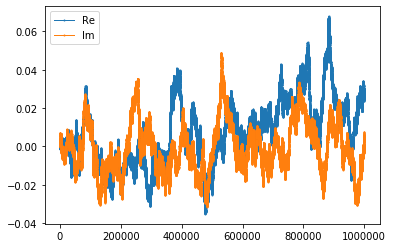

In [9]:
plt.plot(steps, dens_Re, marker='o', markerfacecolor='blue', markersize=1, linewidth=1, label = "Re")
plt.plot(steps, dens_Im, marker='o', markerfacecolor='red', markersize=1, linewidth=1, label = "Im")

# show legend
plt.legend()

# show graph
plt.show()

### Add thermalization and autocorrelation

Import a custom set of functions I wrote, which calculate autocorrelation and error from autocorrelation

In [10]:
from acf import *

Calculate a temporary guess at thermalization (around 20% of the evolution is probably good) and calculate the mean and standard deviation of the observable whose autocorrelation you want to check.

In [11]:
therm_step = int(0.2*steps[-1])
therm_index = int(0.2*len(steps))
dens_avg = np.mean(dens_Re[therm_index:])
dens_sdev = np.std(dens_Re[therm_index:])

Now plot the observable, its average and standard deviation with a vertical line to show thermalization

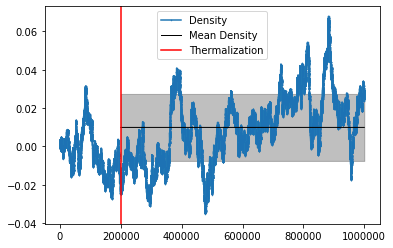

In [12]:
plt.plot(steps, dens_Re, marker='o', markerfacecolor='blue', markersize=0.5, label = "Density")
plt.plot(steps[therm_index:], dens_avg*np.ones_like(steps[therm_index:]), color='black', linewidth=1, label = "Mean Density")
plt.fill_between(steps[therm_index:], dens_avg-dens_sdev, dens_avg+dens_sdev, color = 'black', alpha = 0.25)
plt.axvline(x=therm_step, color = "red", label = "Thermalization")

# show legend
plt.legend()

# show graph
plt.show()

Now calculate the autocorrelation of that observable from the function imported earlier and plot it.

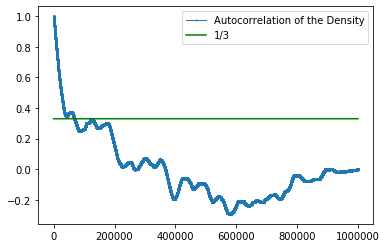

In [13]:
acorr_densRe = autocorr_func_1d(dens_Re)

plt.plot(steps, acorr_densRe, marker='o', markerfacecolor='blue', markersize=1, linewidth=1, label = "Autocorrelation of the Density")
plt.plot(steps, 0.33*np.ones_like(steps), color = "green", label = "1/3")

# show legend
plt.legend()

# show graph
plt.show()

I would like to add a more in-depth analysis of how to choose our spacing using this information, but what I've been taught is the following:
1. To get reasonably good results, you can space your samples so that the autocorrelation is reduced to about 1/3 
2. There's a function you can use to add autocorrelation error to the total error (I'll incorporate this later)
Note that different observables have more autocorrelation than others, so we will need to choose a spacing that's appropriate for the more autocorrelated observables.

## Averaging all the data

For now, let's assume thermalization happens around 20% of the way through the Langevin evolution (we can do a better determination of this later, but for now this is likely a good estimate). For now, we leave out autocorrelation and will add that in later. We will average all the obervables over the final 80% of the evolution and save the results in a pandas table.

First, import the custom functions I've written for this analysis (note for the future: I'd like to combine the acf package with this one)

In [14]:
from nrrb_defs import *

Get a list of every data folder in the main data director. These folders each correspond to a run with one set of parameters on NERSC. Also establish a list of the parameters. This is a standard list and will not change.

In [15]:
subdirs = os.listdir(data_dir)
params_list = ['dim','Nx','Nt','dt','beta','nL','eps','m','mu','wtr','wz','lambda']

Make an empty data frame to store the data

In [16]:
#df_R = pd.DataFrame(columns = params_list+obs_list+err_list)
#df_I = pd.DataFrame(columns = params_list+obs_list+err_list)
#df_params = pd.DataFrame(columns = params_list)
df = pd.DataFrame()

### TO DO: 
- update this function to read in the previously-averaged data from csv
- then it should check for new data (using parameters list)
- average and add new data to the dataframe
- re-export to csv

In [17]:
csv_filename = "averaged_nrrb_data.csv"
df_old = pd.read_csv(csv_filename)

In [18]:
df_new = average_new_data(csv_filename, data_dir, obs_list)

0 new data points added to data frame


In [19]:
df_new.to_csv("new_"+csv_filename, index = False)

## Plot density as a function of chemical potential ($\mu$)

Extract the averaged values from the dataframe. This is a little more complicated because we need to filter by parameters.

In [ ]:
plot_params = {
    'Nx' : 21,
    'Nt' : 80,
    'eps' : 0.01,
    'tL' : 1000,
    'wtr' : 0.0, # trap frequency
    'wz' : 0.0, # rotation frequency
    'lambda' : 0.0, # lambda, contact interaction strength
}
plot_data = df[(df[list(plot_params)] == pd.Series(plot_params)).all(axis=1)]
print(plot_data.shape[0])
print(list(plot_data.columns))
plot_data.head()

In [ ]:
dens_Re = plot_data["Dens (Re)"]
dens_Im = plot_data["Dens (Im)"]
mu = sorted(plot_data["mu"]) #important to sort the x axis value if you're doing a line plot
plt.plot(mu, dens_Re, marker='o', markerfacecolor='blue', markersize=1, linewidth=1, label = "Re")
plt.plot(mu, dens_Im, marker='o', markerfacecolor='red', markersize=1, linewidth=1, label = "Im")

# show legend
plt.legend()

# show graph
plt.show()

add exact solution

Plot some real observables for different eps (same tL) and see how it looks

Visualize density profiles (average)
Also make an animation of the running average of the density profiles

- Circulation will need to be dealt with a little differently than the other observables since we have multiple radii for our circulation loop.
- A question... can we use machine learning to help us with the circulation observable?